# shot2vec model notes
This notebook summarizes the model development process for the shot2vec website. A predictive text approach is taken with the mapping:

*All NHL games* $\Leftrightarrow$ *corpus*

*list of plays from an NHL game* $\Leftrightarrow$ *document*

*serialized representation of a play* $\Leftrightarrow $ *word*

The overall goal of the model is to predict a probability distribution for the next play given the current and previous plays in a given game. This may be done with a recurrent neural network whose input and output spaces are the set of possible plays, and whose output layer has softmax activation (i.e. represents a valid probability distribution).

The initial representation of the plays (words) is categorical. 
Each distinct play (play type, location), corresponds to a distinct one-hot vector in a space whose dimension is the number of distinct plays in the corpus. 
This basis is readable from a human perspective, and can represent a probability distribution over the set of possible plays (the one-hot, i.e. the Kronoker-delta function, is simply on possible distribution). 
On the other hand, if the number of possible plays is large (e.g., if spatial information is included with resonable granularity), it may be difficult for a neural network to learn from a game (document) in this representation. 
The solution to this problem is to create a dense 'embedded' representation of the plays using a variational autoencoder.
In the dense embedded basis, a neural network will have an easier time learning patterns from the games (documents).
We use Gensim's Word2Vec encoding scheme to learn our embedded basis, and train our own softmax layer to decode back to the categorical basis.
These layers are time-distributed, meaning they preform a change of basis on the play vectors which is independent of the time-step (i.e. position within the document).

Within the embedded basis, we use a simple two-layer LSTM recurrent neural network. The output of this network is then transformed to the categorical basis using the softmax layer.

We compare the performance of this model to a baseline model$-$a 1st order Markov model. Which makes predictions by sampling the emperical distribution of plays following the current play. We find an adjusted$^\dagger$ **33% validation accuracy for our model**, compared with **19% accuracy for the baseline model**. 


$^\dagger$To train the neural network, we had to pad all of the games to the same length with trailing placeholder plays. As a result, roughly 36% of the plays in the corpus are padding plays, which are ~trivially predicted by both the baseline and the RNN model, and are reflected in the validation accuracy reported by ```tensorflow.keras```. To calculate the adjusted accuracies, we remove these plays from the picture under the assumption that they are correctly predicted always by both the baseline and RNN models. This assumption is self-evidently true for the baseline Markov model, and appears to be justified for the RNN. 

### Load in the corpus and pad to constant sequence length

First we will load the corpus in to memory (it's only ~150 MB). We will then pad all of the games to the same length so that we may use batch training.

In [1]:
from importlib import reload
import corpse_maker as cm
import data_processing as dp
import model_fns as mf

In [2]:
%%time
STRIP_FN = cm.strip_name_zone
CORPUS = dp.get_corpus(2010, 2018, STRIP_FN)
GAME_LEN = 500
dp.pad_corpus(CORPUS, game_len=GAME_LEN)

CPU times: user 1min 31s, sys: 1min 31s, total: 3min 3s
Wall time: 3min 13s


### Auto-encoding using gensim's word2vec embedding

We will construct the embedding matrix using gensim's word2vec algorithm. The softmax layer may also be trained using an autoencoder structure and the gensim-word2vec embedding matrix. These trained layers may then be used either as untrainable encoding and decoding layers between the initial basis and the embedded basis, or as initial weights for trainable layers with the same purpose.

#### Train the embedding layer
First we train the embedding layer. Gensim's Word2Vec package will return a model where ```wv = model.wv``` is a set of keyed vectors. The keys are the the play strings, sorted in descending order of count, with corresponding zero-origined indices. The values are the embedded representation of the given key (index).

    
```python
wv.vocab[play].index
``` 
is the index of ```play```

```python 
wv.vocab[play].count
``` 
is the number of times ```play``` appears in the corpus

```python
wv[play]
```
is the embedded vector representing ```play```

```python
wv.index2word[index]
``` 
is the ```play``` associated with ```index```


In [3]:
EMBEDDING_DIM = 20
CORPUS_NAME = f'zones_{EMBEDDING_DIM}'

In [4]:
#writes the embedding files
dp.make_embedding(CORPUS_NAME, CORPUS, EMBEDDING_DIM)

In [5]:
import numpy as np
from gensim.models import KeyedVectors
from tensorflow.keras.utils import to_categorical as one_hot
CORPUS_IND = np.load(f'{CORPUS_NAME}.npy')
WV = KeyedVectors.load(f'{CORPUS_NAME}.wv')
CATAGORICAL_DIM = WV.vectors.shape[0]
CORPUS_ONE = one_hot(CORPUS_IND, len(WV.vectors))
EMBEDDING_MATRIX = WV.vectors

#### Train the softmax decoding layer
With the embedding layer quickly calculated, we can train a softmax decoding layer. It's possible that this is unnecessary, and can be done in conjunction with the subsequent hidden layer training, but training one now will provide a sanity check that our embedded representation is minimally lossy, and that it is possible to decode to the original representation. We find a validation accuracy of **.9996** for this autoencoder using a embedding space of dimension 20, suggesting that the embedded representation faithfully encodes almost all of the information about each play.

In [6]:
X_train, X_valid, X_test = dp.tvt_split(CORPUS_IND)
y_train = one_hot(X_train, CATAGORICAL_DIM)
y_valid = one_hot(X_valid, CATAGORICAL_DIM)
y_test = one_hot(X_test, CATAGORICAL_DIM)

In [7]:
%%time
BATCH_SIZE = 200
NUM_EPOCHS = 50
AUTO_ENC = mf.make_decoder_model(EMBEDDING_MATRIX)
AUTO_ENC_HIST = AUTO_ENC.fit(X_train,
                             y_train,
                             epochs=NUM_EPOCHS,
                             batch_size=BATCH_SIZE,
                             validation_data=[X_valid, y_valid],
                            )
softy = AUTO_ENC.layers[1]
np.save(f'{CORPUS_NAME}_softmax', softy.get_weights())

W0814 16:31:54.762890 4652467648 deprecation.py:506] From /Users/tiwariku/environments/shot2vec/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 16:31:54.782175 4652467648 deprecation.py:506] From /Users/tiwariku/environments/shot2vec/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 16:31:55.039746 4652467648 deprecation.py:323] From /Users/tiwariku/environments/shot2vec/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:

Train on 6187 samples, validate on 2062 samples
Epoch 1/50
6187/6187 [==============================] - 5s 802us/sample - loss: 5.5352 - acc: 0.0783 - val_loss: 4.2657 - val_acc: 0.1321
Epoch 2/50
6187/6187 [==============================] - 5s 788us/sample - loss: 3.2135 - acc: 0.2200 - val_loss: 2.3193 - val_acc: 0.6054
Epoch 3/50
6187/6187 [==============================] - 5s 767us/sample - loss: 2.0224 - acc: 0.6086 - val_loss: 1.8272 - val_acc: 0.6074
Epoch 4/50
6187/6187 [==============================] - 5s 783us/sample - loss: 1.6936 - acc: 0.6125 - val_loss: 1.5760 - val_acc: 0.6338
Epoch 5/50
6187/6187 [==============================] - 5s 779us/sample - loss: 1.4742 - acc: 0.6392 - val_loss: 1.3842 - val_acc: 0.6394
Epoch 6/50
6187/6187 [==============================] - 5s 843us/sample - loss: 1.3051 - acc: 0.6738 - val_loss: 1.2378 - val_acc: 0.7389
Epoch 7/50
6187/6187 [==============================] - 5s 803us/sample - loss: 1.1782 - acc: 0.7649 - val_loss: 1.1269 - va

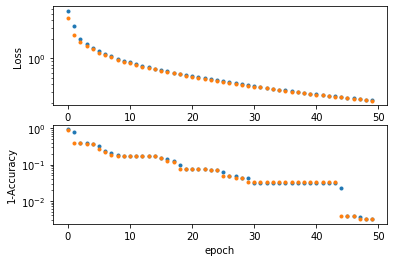

In [10]:
plot_training_summary(AUTO_ENC_HIST)

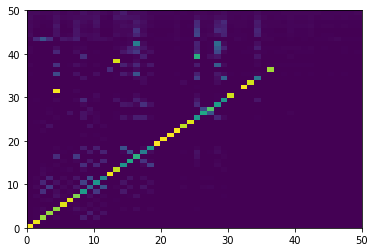

In [13]:
from tensorflow.keras.layers import Embedding, Dense
from tensorflow import keras 

emb_test = Embedding(CATAGORICAL_DIM,
                     EMBEDDING_DIM,
                     weights = [EMBEDDING_MATRIX],
                     trainable=False)
soft_test = Dense(CATAGORICAL_DIM,
                  weights=softy.get_weights(),
                  trainable=False,
                  activation='softmax')
test_model = keras.models.Sequential()
test_model.add(emb_test)
test_model.add(soft_test)
game = np.array([np.linspace(0, CATAGORICAL_DIM-1,CATAGORICAL_DIM),])
plt.pcolormesh((test_model.predict(game))[0])

### Recurrent neural network model
Now that we know our embedded representation is not super lossy, we can move on to train a predictive. Our goal will be to forecast the next play given the current and previous plays. We will do this using two LSTM layers, sandwiched between our autoencoding layers, which will work in the embedded representation.

In [14]:
#this cell resets 
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

In [15]:
%%time
BATCH_SIZE = 400
NUM_STEPS = len(CORPUS_IND[0])-1
NUM_EPOCHS = 50
SOFTMAX_WEIGHTS = np.load(f'{CORPUS_NAME}_softmax.npy',
                          allow_pickle=True)

X_train, X_valid, _ = dp.tvt_split(CORPUS_IND)
y_train = one_hot(X_train, CATAGORICAL_DIM)
y_valid = one_hot(X_valid, CATAGORICAL_DIM)

# the length must be divisible by the batch size
train_len = len(X_train)//BATCH_SIZE*BATCH_SIZE
valid_len = len(X_valid)//BATCH_SIZE*BATCH_SIZE

# offset the targets from the inputs by one play
X_train = X_train[:train_len,:-1]
X_valid = X_valid[:valid_len,:-1]
y_train = y_train[:train_len,1:]
y_valid = y_valid[:valid_len,1:]

CPU times: user 189 ms, sys: 209 ms, total: 398 ms
Wall time: 396 ms


In [ ]:
#load the saved softmax weights. This might not be necessary
SOFTMAX_WEIGHTS = np.load(f'{CORPUS_NAME}_softmax.npy',
                          allow_pickle=True)

RNN_MODEL = mf.make_rnn_training_model(embedding_matrix=EMBEDDING_MATRIX,
                            softmax_weights=SOFTMAX_WEIGHTS,
                            batch_size=BATCH_SIZE,
                            num_steps=NUM_STEPS,
                            train_softmax=False,
                            train_embedding=False,)

RNN_HIST = RNN_MODEL.fit(X_train,
                         y_train,
                         epochs=NUM_EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=[X_valid, y_valid],)

In [ ]:
plot_training_summary(RNN_HIST)

In [18]:
NUM_EPOCHS = 100
RNN_MODEL_SOFT_FIT = mf.make_rnn_training_model(embedding_matrix=EMBEDDING_MATRIX,
                            softmax_weights=SOFTMAX_WEIGHTS,
                            batch_size=BATCH_SIZE,
                            num_steps=NUM_STEPS,
                            train_embedding=False,
                            train_softmax=True)

RNN_S_HIST = RNN_MODEL_SOFT_FIT.fit(X_train,
                         y_train,
                         epochs=NUM_EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=[X_valid, y_valid],)

Train on 6000 samples, validate on 2000 samples
Epoch 1/100
6000/6000 [==============================] - 17s 3ms/sample - loss: 3.8213 - acc: 0.0512 - val_loss: 3.6487 - val_acc: 0.0517
Epoch 2/100
6000/6000 [==============================] - 16s 3ms/sample - loss: 3.4797 - acc: 0.2898 - val_loss: 3.2965 - val_acc: 0.4121
Epoch 3/100
6000/6000 [==============================] - 16s 3ms/sample - loss: 3.1452 - acc: 0.4150 - val_loss: 2.9775 - val_acc: 0.4145
Epoch 4/100
6000/6000 [==============================] - 16s 3ms/sample - loss: 2.8281 - acc: 0.4181 - val_loss: 2.6646 - val_acc: 0.4478
Epoch 5/100
6000/6000 [==============================] - 16s 3ms/sample - loss: 2.5228 - acc: 0.4547 - val_loss: 2.3823 - val_acc: 0.4533
Epoch 6/100
6000/6000 [==============================] - 16s 3ms/sample - loss: 2.2852 - acc: 0.4567 - val_loss: 2.2061 - val_acc: 0.4557
Epoch 7/100
6000/6000 [==============================] - 16s 3ms/sample - loss: 2.1518 - acc: 0.4584 - val_loss: 2.1118 - va

6000/6000 [==============================] - 17s 3ms/sample - loss: 1.4551 - acc: 0.5654 - val_loss: 1.4587 - val_acc: 0.5637
Epoch 60/100
6000/6000 [==============================] - 17s 3ms/sample - loss: 1.4532 - acc: 0.5656 - val_loss: 1.4569 - val_acc: 0.5640
Epoch 61/100
6000/6000 [==============================] - 17s 3ms/sample - loss: 1.4515 - acc: 0.5658 - val_loss: 1.4552 - val_acc: 0.5641
Epoch 62/100
6000/6000 [==============================] - 17s 3ms/sample - loss: 1.4498 - acc: 0.5661 - val_loss: 1.4535 - val_acc: 0.5646
Epoch 63/100
6000/6000 [==============================] - 17s 3ms/sample - loss: 1.4481 - acc: 0.5663 - val_loss: 1.4519 - val_acc: 0.5647
Epoch 64/100
6000/6000 [==============================] - 17s 3ms/sample - loss: 1.4466 - acc: 0.5665 - val_loss: 1.4504 - val_acc: 0.5652
Epoch 65/100
6000/6000 [==============================] - 17s 3ms/sample - loss: 1.4451 - acc: 0.5684 - val_loss: 1.4490 - val_acc: 0.5673
Epoch 66/100
6000/6000 [================

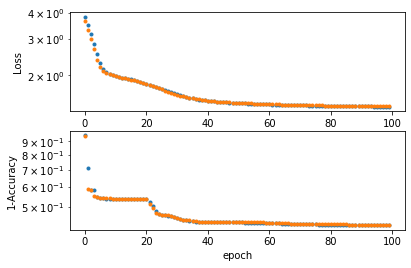

In [19]:
plot_training_summary(RNN_S_HIST)

#### RNN evaluation
Roughly 35% of the plays are actually just padding at the end of the game. The RNN probably gets those right, and the Markov chain definitely does. We should consider the accuracy excluding these predictions when assessing the quality of the model. This can be done by recalculating the accuracy assuming all of the pad plays were correctly predicted. The result is a lower bound on the accuracy of the RNN with respect to in-game plays. We find an adjusted **validation accuracy of .3303 for the RNN model**, which drastically outpreforms the **.1902 validation accuracy of the baseline model**.

In [20]:
num_games, num_plays = CORPUS_IND.shape
pad_percent = WV.vocab[str({'Type':'Pad'})].count/(num_games*num_plays)
valid_percent = 1-pad_percent
RNN_val_acc = .5780 #best for a longer training session()
MC1_val_acc = .4911 #see baseline_models.py
RNN_adj_acc = np.round((RNN_val_acc-pad_percent)/valid_percent,4)
MC1_adj_acc = np.round((MC1_val_acc-pad_percent)/valid_percent,4)
print(f'RNN adjusted validation accuracy = {RNN_adj_acc}')
print(f'1st order markov chain adjusted validation accuracy = {MC1_adj_acc}')

RNN adjusted validation accuracy = 0.3303
1st order markov chain adjusted validation accuracy = 0.1924


#### Saving the models
We'll have to save the trained model so we can use it on the website. 

```python
model_json = model.to_json()
```
creates a json of the model architecture in ```model_json```
 
```python 
with open("model.json", "w") as json_file:
    json_file.write(model_json)
```
writes the json to the file ```model.json```

```python
model.save_weights("model.h5")
```
saves the weights of ```model``` in the file ```model.h5```

In [21]:
model_json = RNN_MODEL_SOFT_FIT.to_json()
with open(f"RNN_MODEL_SOFT_FIT.json", "w") as json_file:
    json_file.write(model_json)
RNN_MODEL_SOFT_FIT.save_weights(f"RNN_MODEL_SOFT_FIT.h5")

#### Loading the models
The model architecture and weights can be reloaded form these files:
```python
with open("model.json", "rb") as json_file:
    loaded_model_json = json_file.read()
```
loads the architecture in json form the file, 

```python
loaded_model = model_from_json(loaded_model_json)
```
creates the model (requires ```from tensorflow.keras.models import model_from_json```),

```python
loaded_model.load_weights("model.h5")
```
loads the weights.

In reality, we will want a new model with a different input batch size, ```(1, None)```, for (```num_games, time_step```) for our predictions. This is done with the function ```make_rnn_predicting_model(hdf5_file, cat_dim, emb_dim)```, which takes a path to a weights file, and the dimensionality of the categorical and embedded spaces as arguments.

# Scratch

In [ ]:
from tensorflow.keras.models import model_from_json
with open("RNN_MODEL_SOFT_FIT.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
loaded_model._layers[0].batch_size = None

In [ ]:
cat_dim, emb_dim = EMBEDDING_MATRIX.shape
hdf5_file = f"RNN_MODEL_SOFT_FIT.h5"
RNN_PRED = mf.make_rnn_predicting_model(hdf5_file, cat_dim, emb_dim)

In [ ]:
from tensorflow.keras.models import model_from_json
def load_model_json(filename):
    with open(filename, "r") as json_file:
        loaded_model_json = json_file.read()
    return model_from_json(loaded_model_json)

def save_model_json(model, filename):
    model_json = model.to_json()
    with open(filename, "w") as json_file:
        json_file.write(model_json)
        
RNN_MODEL_SOFT_FIT.save_weights(f"RNN_MODEL_SOFT_FIT.h5")

In [ ]:
filename = 'RNN_PRED.json'
save_model_json(RNN_PRED, filename)
RNN_PRED.save_weights('RNN_PRED.h5')

test_mod = load_model_json(filename)
test_mod.load_weights("RNN_PRED.h5")
test_mod.predict([0, 0, 0])

In [ ]:
GAME = 3
START = 0
STOP = 10
INPUT_PLAYS = CORPUS_IND[GAME,START:STOP]
ACTUAL_NEXT = CORPUS_IND[GAME, (START+1):(STOP+1)]
RNN_PRED.reset_states()
PRED = RNN_PRED.predict(INPUT_PLAYS)[:,0]
print(RNN_PRED.predict(INPUT_PLAYS).shape)
MAX_PROB_NEXT = np.argmax(PRED, axis=1)[:]
ACTUAL_PROB_NEXT = [np.round(PRED[i, actual_ind],2) for i, actual_ind in enumerate(ACTUAL_NEXT)]
PRED.shape

In [ ]:
print(INPUT_PLAYS)
print(ACTUAL_NEXT)
print(MAX_PROB_NEXT)
print(ACTUAL_PROB_NEXT)

In [ ]:
for i, play, in enumerate(WV.index2word):
    print(i, play)
WV.index2word[12]

# Scratch

In [ ]:
import keras.utils.vis_utils as vsutil

In [ ]:
print(RNN_PRED.summary())

In [ ]:
import sys
print(sys.executable)

In [ ]:
!/Users/tiwariku/environments/shot2vec/bin/python3 -m pip install pydot

In [ ]:
vsutil.model_to_dot(RNN_PRED)

In [ ]:
pad_percent

In [ ]:
x = np.linspace(-10,10,1000)
y = np.sign(x)*np.log(np.abs(x+np.sign(x)))
plt.plot(x,y)

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.utils import to_categorical as one_hot
import numpy as np
from sklearn.model_selection import train_test_split

def wv_index_corpus(corpus, wv):
    """
    in  corpus, a corpus with plays in string-serialized format
            and 
        wv, the assocated wordvector object
        
    out: corpus_index, the corpus in index format
    """
    corpus_index = np.zeros((len(corpus), len(corpus[0])), dtype=np.int32)
    for gi, game in enumerate(corpus):
        for pi, play in enumerate(game):
            corpus_index[gi, pi] =  wv.vocab[play].index
    return corpus_index

def make_embedding(name, 
                   corpus, 
                   embedding_size, 
                   window=5, 
                   min_count=1, 
                   workers=4):
    """
    Trains a gensim word2vec model on the corpus, 
        saves the indexed corpus and wordvectors
    in:
        name, the filename associated with this embedding scheme
        corpus, the corpus to train on (in serialized play-dict format)
        embedding_size, the size of the embedded representation
        window=5, the max skip-gram for the word2vec
        min_count=1, min count for word2vec
        workers=4, number of workers to use by gensim
    """
    model = Word2Vec(corpus,
                     size=embedding_size,
                     window=window,
                     min_count=min_count,
                     workers=workers)
    model.wv.save(f'{name}.wv')
    corpus_index = wv_index_corpus(corpus, model.wv)
    np.save(name, corpus_index)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
def make_decoder_model(embedding_matrix):
    """
    makes a compiled variational autoencoder model with 
    un-trainable embedding layer whose weights are specified by...
    in:
        embedding matrix
    """
    cat_dim, emb_dim = embedding_matrix.shape
    embed = Embedding(cat_dim,
                  emb_dim,
                  #batch_input_shape = (batch_size, num_steps),
                  weights=[embedding_matrix],
                  trainable=False)
    old_softy = TimeDistributed(Dense(cat_dim, 
                                      activation='softmax'))
    model = keras.models.Sequential()
    model.add(embed)
    model.add(old_softy)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def fit_softmax(data, num_epochs, batch_size, embedding_matrix):
    """
    Unused, this should probably just be in the main script
    """
    X_train, X_valid, y_train, y_valid = data
    auto_enc = make_decoder_model(EMBEDDING_MATRIX)
    auto_enc_hist = auto_enc.fit(X_train,
                             y_train,
                             epochs=num_epochs,
                             batch_size=batch_size,
                             validation_data=[X_valid, y_valid],
                            ) 
    return auto_enc, auto_enc_hist



In [ ]:
from tensorflow.keras.layers import LSTM
def make_rnn_training_model(embedding_matrix,
                            softmax_weights,
                            batch_size,
                            num_steps,
                            train_embedding=True,
                            train_softmax=True,):
    """
    returns a compiled RNN model with two lstm layers of 
    size 'embeddeding_size'
    """
    cat_dim, emb_dim = embedding_matrix.shape
    layers = []
    embed = Embedding(cat_dim,
                  emb_dim,
                  batch_input_shape = (batch_size, num_steps),
                  weights=[embedding_matrix],
                  trainable=train_embedding)
    lstm1 = LSTM(emb_dim,
                 #batch_input_shape = (batch_size, num_steps, embedded_dim),
                 stateful=True,
                 return_sequences=True,
                )
    lstm2 = LSTM(emb_dim,
                 #batch_input_shape = (batch_size, num_steps, embedded_dim),
                 stateful=True,
                 return_sequences=True,
                )
    old_softy = TimeDistributed(Dense(cat_dim, 
                                      weights=softmax_weights,
                                      trainable=train_softmax,
                                      activation='softmax'))
    model = keras.models.Sequential()
    model.add(embed)
    model.add(lstm1)
    model.add(lstm2)
    model.add(old_softy)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model 

def make_rnn_predicting_model(hdf5_file, cat_dim, emb_dim):
    """
    returns a compiled RNN model with two lstm layers of 
    size 'embeddeding_size'
    """
    #cat_dim, emb_dim = embedding_matrix.shape
    layers = []
    embed = Embedding(cat_dim,
                  emb_dim,
                  batch_input_shape = (1, None),
                  #weights=[embedding_matrix],
                  #trainable=False
                     )
    lstm1 = LSTM(emb_dim,
                 #batch_input_shape = (batch_size, num_steps, embedded_dim),
                 stateful=True,
                 return_sequences=True,
                )
    lstm2 = LSTM(emb_dim,
                 #batch_input_shape = (batch_size, num_steps, embedded_dim),
                 stateful=True,
                 return_sequences=True,
                )
    old_softy = TimeDistributed(Dense(cat_dim, 
                                      #weights=softmax_weights,
                                      #trainable=train_softmax,
                                      activation='softmax'))
    model = keras.models.Sequential()
    model.add(embed)
    model.add(lstm1)
    model.add(lstm2)
    model.add(old_softy)
    model.load_weights(hdf5_file)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model 

In [9]:
import matplotlib.pyplot as plt
def plot_training_summary(history):
    """
    Plots the validation and training accuracy and loss
    of a keras history
    """
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    ax.semilogy(history.history['loss'], '.', label='Train')
    ax.semilogy(history.history['val_loss'],'.',  label='Val')
    ax.set_ylabel('Loss')
    ax = fig.add_subplot(2,1,2)
    ax.semilogy(1-np.array(history.history['acc']), '.', label='Train')
    ax.semilogy(1-np.array(history.history['val_acc']),'.',  label='Val')
    ax.set_ylabel('1-Accuracy')
    ax.set_xlabel('epoch')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
load_model("RNN_MODEL_SOFT_FIT.h5")

In [ ]:
!ls